Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)
========================================

Here, we focus on the EEGBCI dataset which is documented in [2] and can be downloaded at 
[PhysioNet](https://physionet.org/pn4/eegmmidb/). The dataset contains EEG recordings
of motor imagery.

A target appears on either the top or the bottom of the screen. A subject imagines 
opening and closing either both fists (if the target is on top) or both feet 
(if the target is on the bottom) until the target disappears. Each subject performed
3 experimental runs of motor imagery.

Here, we will 'decode', or in other words, predict the target from the EEG signals.
To do so, we will use a [Common Spatial Pattern (CSP)](http://en.wikipedia.org/wiki/Common_spatial_pattern) [1] to extract the features for classification.

References
----------

1. Zoltan J. Koles. The quantitative extraction and topographic mapping
   of the abnormal components in the clinical EEG. Electroencephalography
   and Clinical Neurophysiology, 79(6):440--447, December 1991.
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N.,
   Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface
   (BCI) System. IEEE TBME 51(6):1034-1043.

First let us read the list of filenames we want to read

In [1]:
from mne.datasets import eegbci

subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

# The data will be downloaded (approximately 7.5 MB)
raw_fnames = eegbci.load_data(subject, runs)

**Q1.** Can you see what is inside `raw_fnames`?

In [2]:
# your code here

Let us read in the files now

In [3]:
from mne.io import concatenate_raws, read_raw_edf

raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raw_files)

Extracting edf Parameters from /home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.


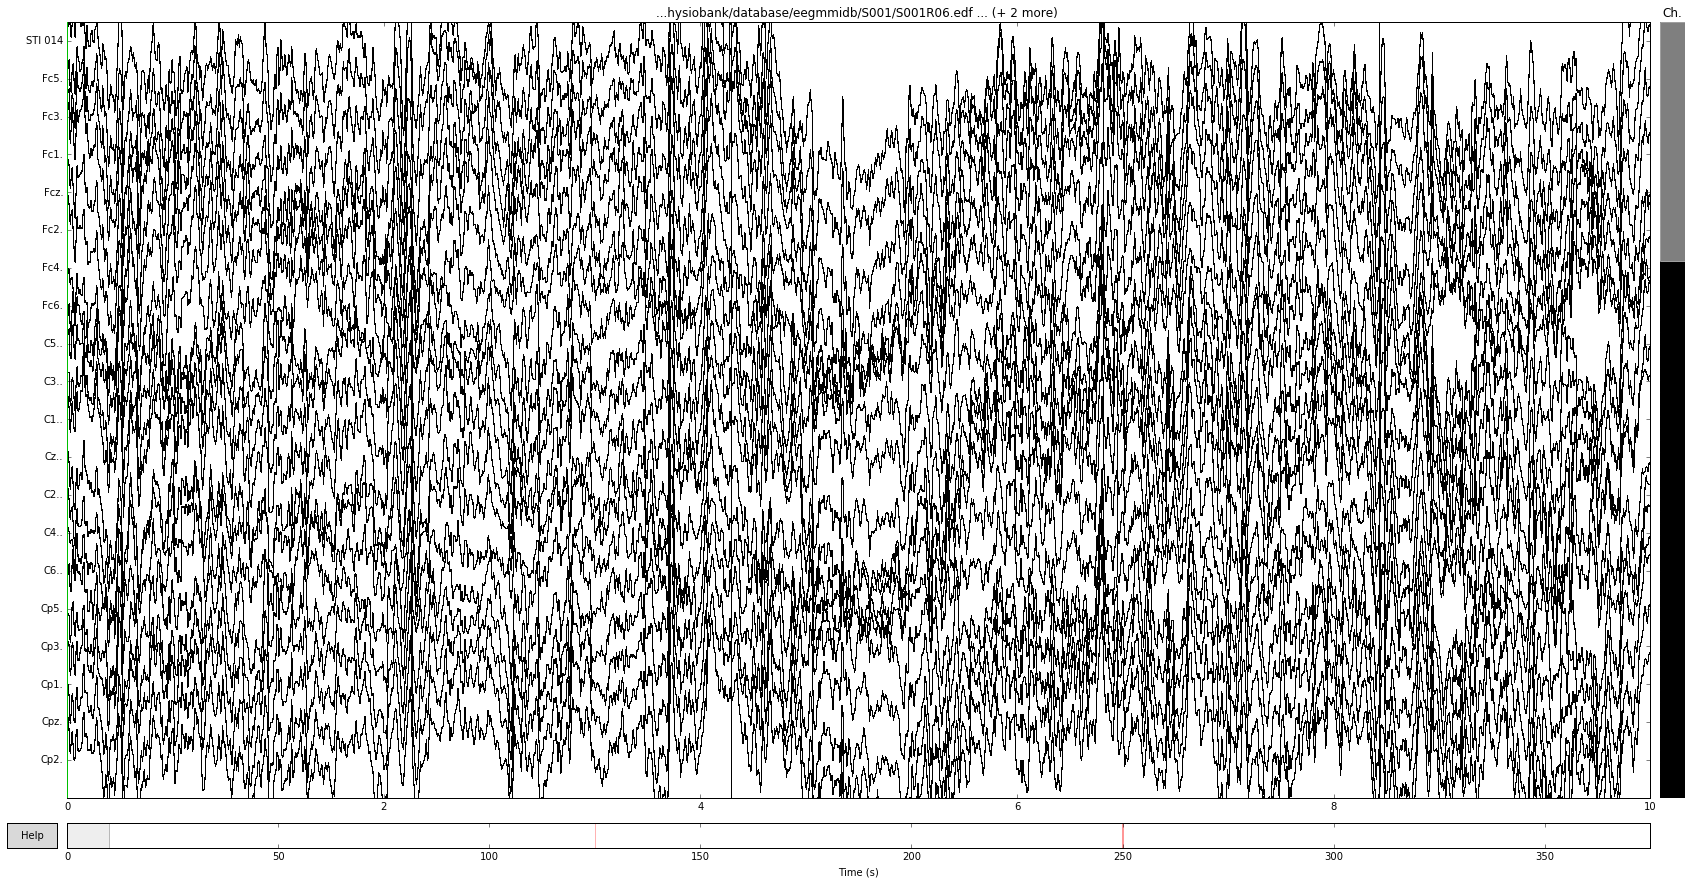

In [4]:
%matplotlib inline
# %matplotlib qt
raw.plot();

Let us read in the layout of the channels for the 10-05 system. This is an internationally recognized nomenclature to specify the location of the electrodes.

In [5]:
from mne.channels import read_layout
layout = read_layout('EEG1005')
', '.join(layout.names)

'Fp1, Fpz, Fp2, AF9, AF7, AF5, AF3, AF1, AFz, AF2, AF4, AF6, AF8, AF10, F9, F7, F5, F3, F1, Fz, F2, F4, F6, F8, F10, FT9, FT7, FC5, FC3, FC1, FCz, FC2, FC4, FC6, FT8, FT10, T9, T7, C5, C3, C1, Cz, C2, C4, C6, T8, T10, TP9, TP7, CP5, CP3, CP1, CPz, CP2, CP4, CP6, TP8, TP10, P9, P7, P5, P3, P1, Pz, P2, P4, P6, P8, P10, PO9, PO7, PO5, PO3, PO1, POz, PO2, PO4, PO6, PO8, PO10, O1, Oz, O2, I1, Iz, I2, AFp9h, AFp7h, AFp5h, AFp3h, AFp1h, AFp2h, AFp4h, AFp6h, AFp8h, AFp10h, AFF9h, AFF7h, AFF5h, AFF3h, AFF1h, AFF2h, AFF4h, AFF6h, AFF8h, AFF10h, FFT9h, FFT7h, FFC5h, FFC3h, FFC1h, FFC2h, FFC4h, FFC6h, FFT8h, FFT10h, FTT9h, FTT7h, FCC5h, FCC3h, FCC1h, FCC2h, FCC4h, FCC6h, FTT8h, FTT10h, TTP9h, TTP7h, CCP5h, CCP3h, CCP1h, CCP2h, CCP4h, CCP6h, TTP8h, TTP10h, TPP9h, TPP7h, CPP5h, CPP3h, CPP1h, CPP2h, CPP4h, CPP6h, TPP8h, TPP10h, PPO9h, PPO7h, PPO5h, PPO3h, PPO1h, PPO2h, PPO4h, PPO6h, PPO8h, PPO10h, POO9h, POO7h, POO5h, POO3h, POO1h, POO2h, POO4h, POO6h, POO8h, POO10h, OI1h, OI2h, Fp1h, Fp2h, AF9h, AF7

We can also get the locations [x, y, width, height]

In [6]:
layout.pos

array([[ 0.37659695,  0.84300649,  0.01628242,  0.01221188],
       [ 0.49096987,  0.86111964,  0.01628242,  0.01221188],
       [ 0.60538355,  0.84301804,  0.01628242,  0.01221188],
       ..., 
       [ 0.61965801,  0.09491906,  0.01628242,  0.01221188],
       [ 0.02825243,  0.90330014,  0.01628242,  0.01221188],
       [ 0.95368731,  0.90330014,  0.01628242,  0.01221188]])

However, the recordings here are in the 10-10 system, which is lower resolution. Therefore, we must pick a subset of the sensors. But first, let us remove the "." character at the end of the channel names.

In [7]:
# strip channel names of "." characters
print(raw.ch_names[:5])
raw.rename_channels(lambda x: x.strip('.'))
print(raw.ch_names[:5])

[u'Fc5.', u'Fc3.', u'Fc1.', u'Fcz.', u'Fc2.']
[u'Fc5', u'Fc3', u'Fc1', u'Fcz', u'Fc2']


Now, we can index the channels in `layout.ch_names` object using `picks`

In [8]:
from mne import pick_channels
picks = pick_channels(layout.names, raw.ch_names)
print(picks)

[ 0  1  2 15 16 17 18 19 20 21 22 23 36 37 38 39 40 41 42 43 44 45 46 59 60
 61 62 63 64 65 66 67 80 81 82 84]


** Q2 ** MNE provides other pick functions such as `pick_types` and `pick_channels_regexp` (for using a regular expression to index). Can you get a list of all the channel names in `raw.ch_names` which start with 'F' (that is the frontal channels)?

In [9]:
# your code here
# HINT: The regular expression to match starting with F is: ^F

Finally, to plot the layout, we do:

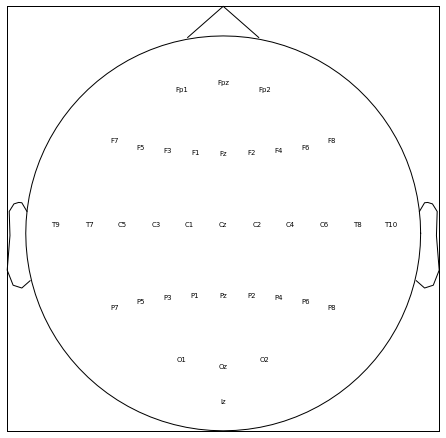

In [10]:
layout.plot(picks);

Now, we apply a band-pass filter. 'Band pass' refers to the fact that we remove both low frequency fluctuations and high-frequency fluctuations. In other words, we are interested only in the frequency band of 7 Hz to 30 Hz, a range that is often implicated in motor imagery tasks.

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected


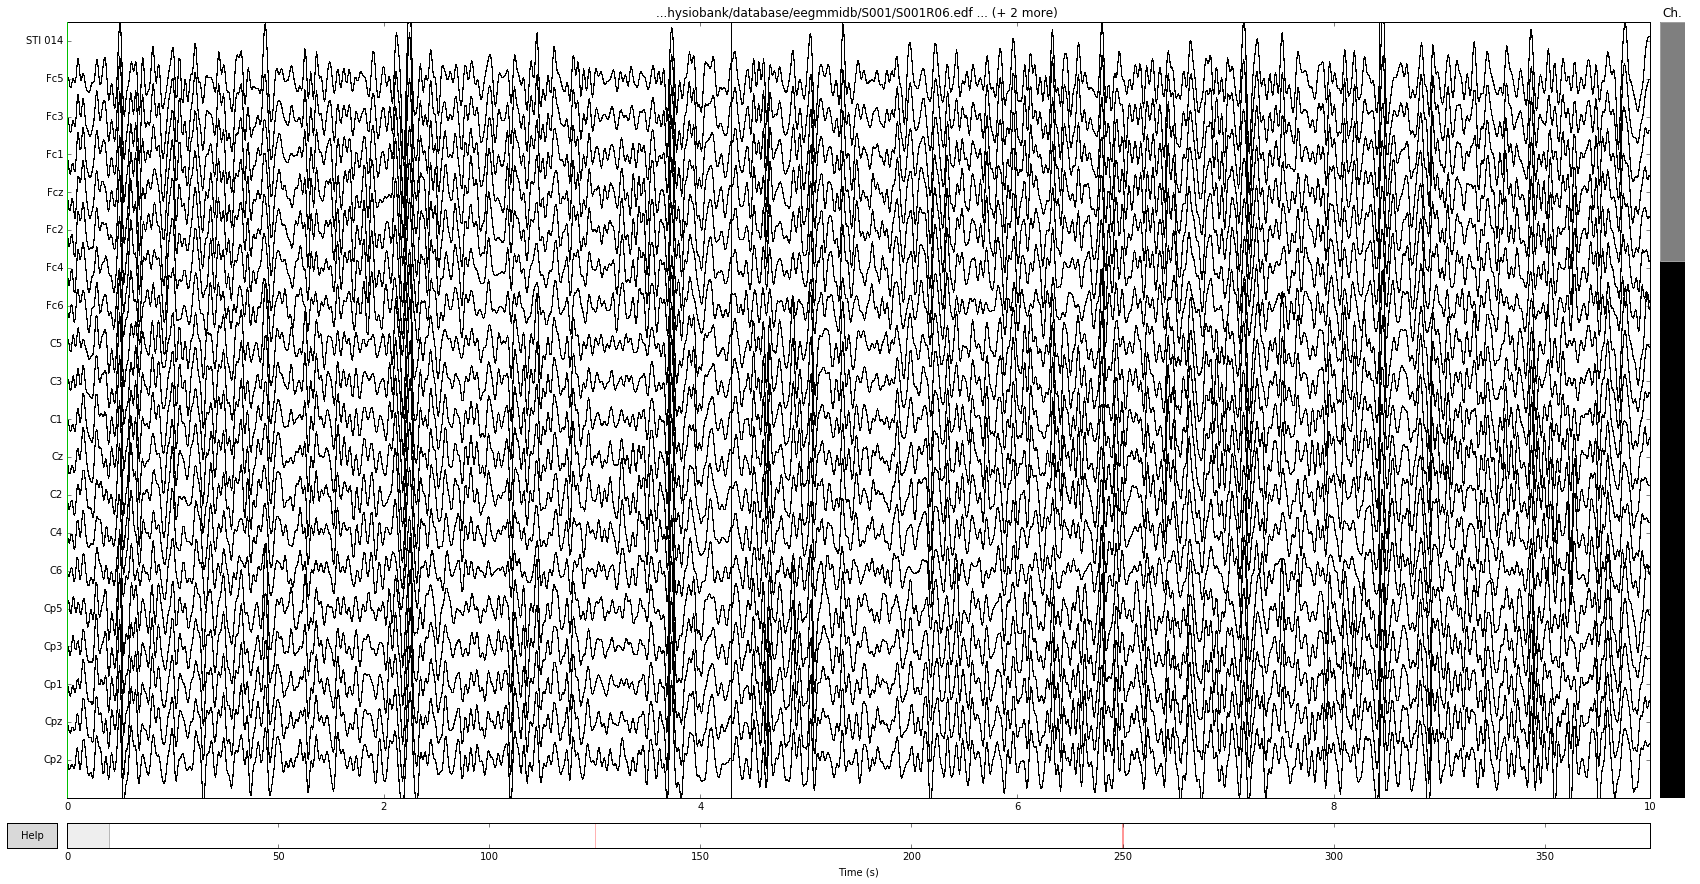

In [11]:
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin')
raw.plot();

The info attribute contains all the metadata

In [12]:
print(raw.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, ...
    chs : list | 65 items (EEG: 64, MISC: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    highpass : float | 7.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 30.0 Hz
    meas_date : int | 1250093700
    nchan : int | 65
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>


Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
event 1 missing from event_id will be ignored


<ipython-input-13-66a92cacbbc1>:7: RuntimeWarning: event 1 missing from event_id will be ignored
  plot_events(events, raw.info['sfreq'], event_id=event_id);


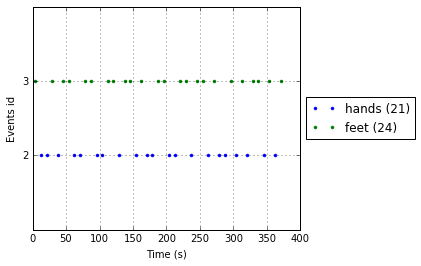

In [13]:
%matplotlib inline
from mne import find_events
from mne.viz import plot_events

event_id = dict(hands=2, feet=3)
events = find_events(raw, shortest_event=0, stim_channel='STI 014')
plot_events(events, raw.info['sfreq'], event_id=event_id);

In [14]:
from mne import Epochs, pick_types

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

tmin, tmax = -1., 4.
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


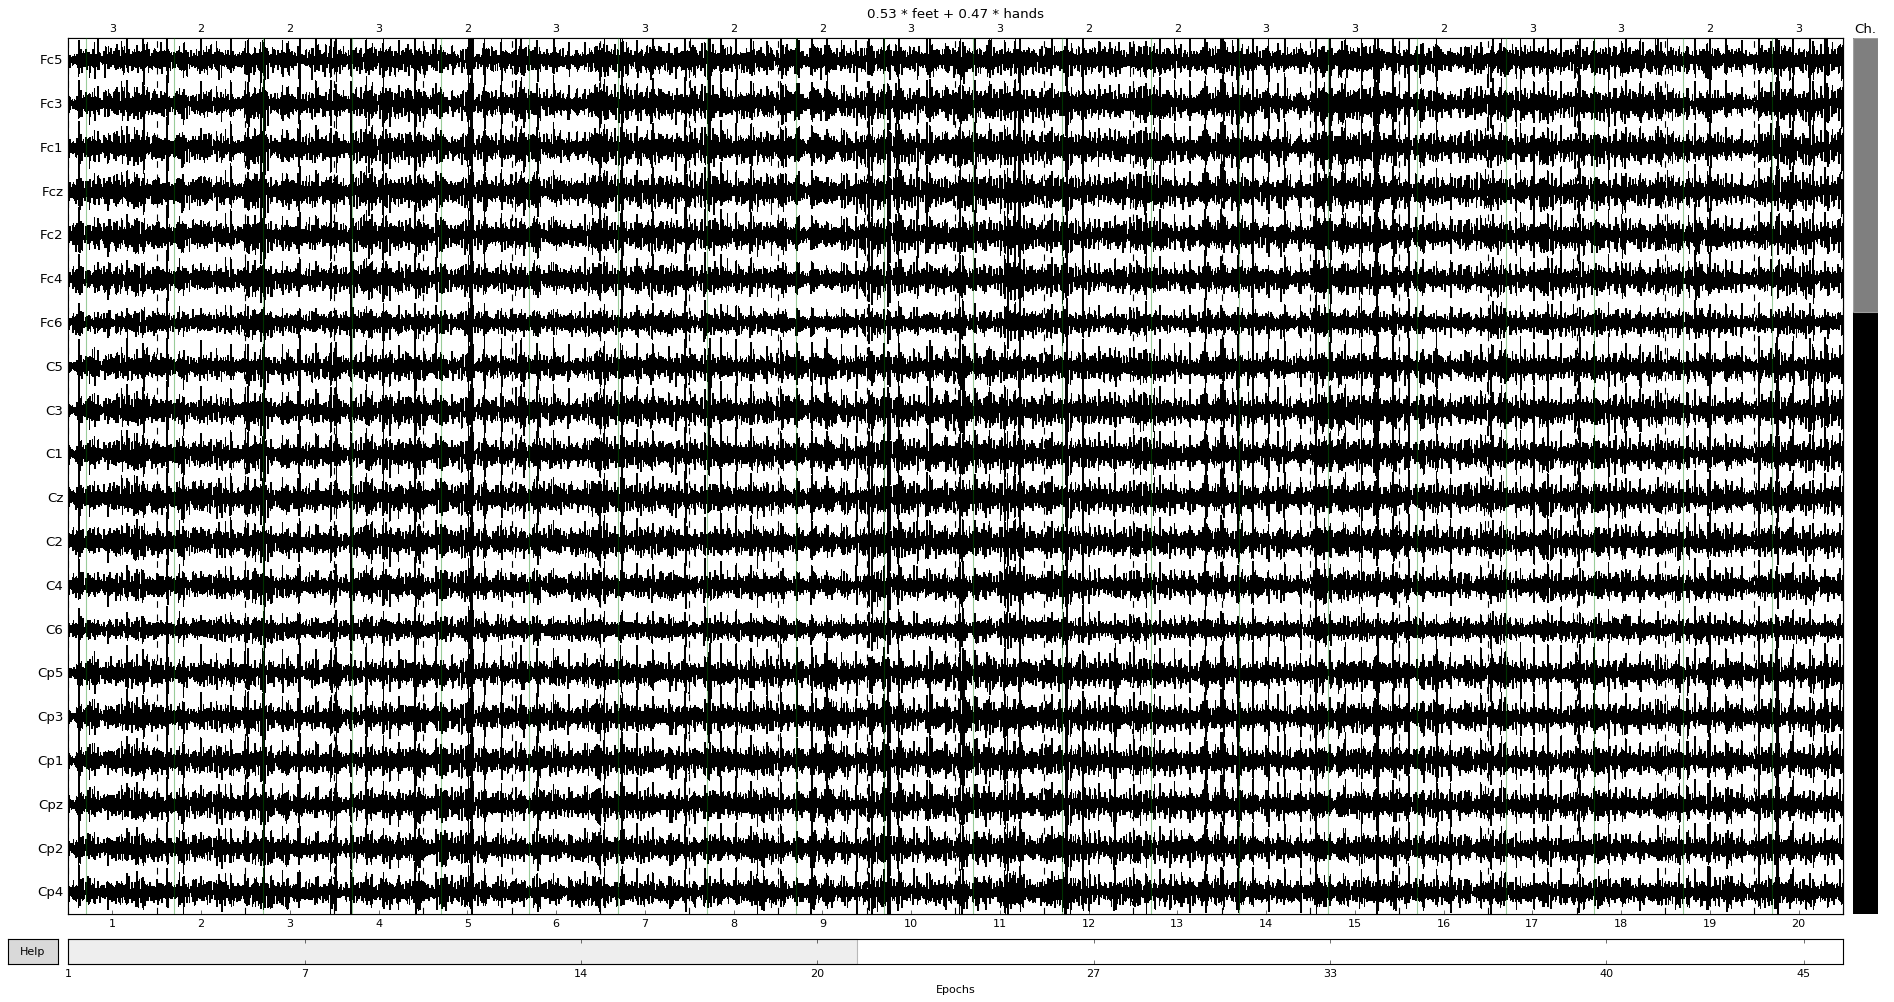

In [15]:
epochs.plot(scalings=dict(eeg=100e-6));

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

Now, we can construct a Pipeline. CSP is a preprocessing step that will extract the spatial patterns that maximally separate the two classes. LDA will perform classification on these features?

In [17]:
from sklearn.pipeline import Pipeline

clf = Pipeline([('CSP', csp), ('LDA', lda)])
print(clf)

Pipeline(steps=[('CSP', CSP(cov_est='concat', log=True, n_components=4, norm_trace=False, reg=None,
  transform_into='average_power')), ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))])


In [18]:
# (train will be done only between 1 and 2s)

epochs_train = epochs.copy().crop(tmin=1., tmax=2.)

epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

Let's use cross validation to evaluate our classifier

In [19]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Define a monte-carlo cross-validation generator (reduce variance):
labels = epochs.events[:, -1] - 2
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
print(scores)

[ 0.88888889  1.          1.          0.88888889  1.          0.88888889
  1.          1.          0.77777778  0.88888889]


** Q3 ** Often the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) can provide a more visual interpretation of what classes are misclassified. Can you compute it for our classifier?

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# your code below

Classification with linear discrimant analysis



In [21]:
import numpy as np

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Classification accuracy: 0.933333 / Chance level: 0.533333


Now, let us plot the CSP patterns estimated on full data for visualization.
The patterns show how the data can be reconstructed from the CSP components.
These patterns tell us which features are important for the classification.

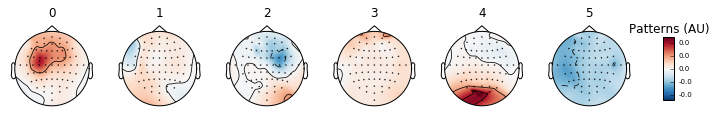

In [22]:
csp.fit_transform(epochs_data, labels)

evoked = epochs.average()
evoked.data = csp.patterns_.T
evoked.times = np.arange(evoked.data.shape[0])

evoked.plot_topomap(times=[0, 1, 2, 3, 4, 5], ch_type='eeg', layout=layout,
                    scale_time=1, time_format='%i', scale=1,
                    unit='Patterns (AU)', size=1.5);